## Importing All libraries used

In [50]:
from pathlib import Path
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
import hashlib
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

## Taking Info on the Dataset

In [9]:

root = Path("CBD_Coffee Bean Dataset") 
dir_names = []
for fnames in root.iterdir():
    if fnames.is_dir():
        dir_names.append(fnames.name)

classes = sorted(dir_names)

rows=[]
for c in classes:
    files=list((root/c).glob("*.*"))  #looking at each file in the directory and storing in the list
    for f in files:  #looping through every single file in each directory
        try:
            width,height=Image.open(f).size
            rows.append({"class":c,"file":str(f),"width":width,"height":height})
        except:
            rows.append({"class":c,"file":str(f),"width":None,"height":None,"corrupt":True})
df=pd.DataFrame(rows)
df.groupby("class").size().reset_index(name="count").to_csv("class_counts.csv",index=False)
df.to_csv("dataset_summary.csv",index=False)



## Exploratory Data Analysis (EDA)

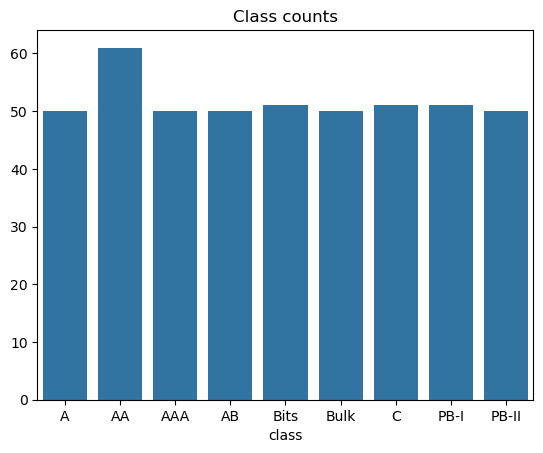

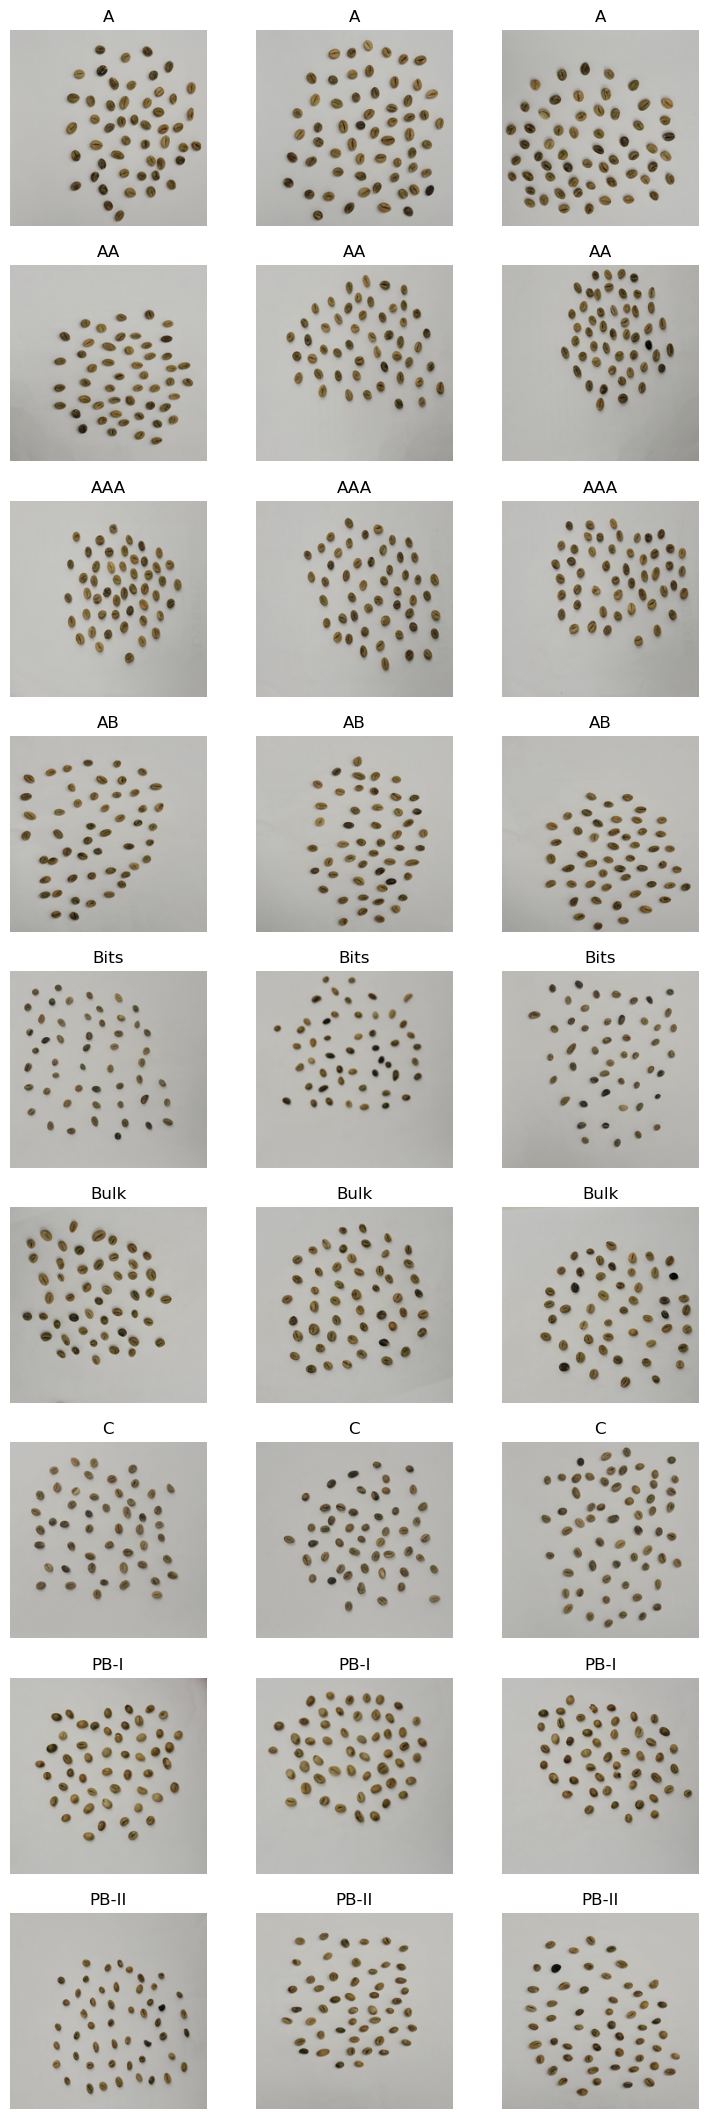

In [10]:

# barchart
counts = df['class'].value_counts().sort_index()
sns.barplot(x=counts.index, y=counts.values)
plt.title("Class counts")


# B: thumbnails (3 each)
sample = df.groupby("class").sample(n=3, random_state=0)  # 3 samples per class
cols = 3
rows = len(sample['class'].unique())
fig, axes = plt.subplots(rows, cols, figsize=(cols*3, rows*3))
for (i, (idx, row)) in enumerate(sample.iterrows()):
    r = i // cols; c = i % cols  #used AI to help with code here
    im = Image.open(row['file']).convert('RGB').resize((224,224))
    axes[r,c].imshow(im); axes[r,c].axis('off'); axes[r,c].set_title(row['class'])


In [11]:
root = Path("CBD_Coffee Bean Dataset") 
rows = []

# Checking each image for corruption
valid_exts = {".jpg"}
for img_path in root.rglob("*"):
    if img_path.suffix.lower() not in valid_exts:
        continue
    try:
        with Image.open(img_path) as im:
            im.verify()  # verifies integrity
        status = "ok"
    except Exception as e:
        status = "corrupt"
    rows.append({"file": str(img_path), "status": status})

df_status = pd.DataFrame(rows)
print(f"Scanned {len(df_status)} files total")

# Counting corrupt files
corrupt_count = (df_status["status"] == "corrupt").sum()
print(f"Corrupt images found: {corrupt_count}")

# Detecting duplicates by file hash
hashes = {}
duplicates = []

for f in df_status[df_status["status"] == "ok"]["file"]:
    path = Path(f)
    try:
        h = hashlib.md5(path.read_bytes()).hexdigest()
        if h in hashes:
            duplicates.append((path, hashes[h]))
        else:
            hashes[h] = path
    except Exception as e:
        print(f"Skipping unreadable file: {path}")

duplicate_count = len(duplicates)
print(f"Duplicate images found: {duplicate_count}")

# Saving results
df_status.to_csv("Dataset_integrity_check.csv", index=False)
print("Results saved to Dataset_integrity_check.csv")

Scanned 464 files total
Corrupt images found: 0
Duplicate images found: 0
Results saved to Dataset_integrity_check.csv


## Preprocessing Image attributes

In [12]:
from torchvision import transforms  #used help of ai for which attributes to adjust

train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

eval_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])


## Making train, test and validation splits

In [13]:
# First Split: Creating train and test sets 

traint, test = train_test_split(
    df,
    test_size=0.15,
    stratify=df['class'], # using stratify to ensure all 9 coffee classes appear in both train and test sets
    random_state=42
)

# Second Split: Creating train and validation sets
# 0.1765 * 0.85 ≈ 0.15 => final splits 70/15/15
train, val = train_test_split(
    traint,
    test_size=0.1765,
    stratify=traint['class'], 
    random_state=42
)

# Saving the new splits to CSV files
for name, d in [('train', train), ('val', val), ('test', test)]:
    d.to_csv(f"{name}.csv", index=False)

print("Split sizes:")
print(f"Train: {len(train)}")
print(f"Validation: {len(val)}")
print(f"Test: {len(test)}")


Split sizes:
Train: 324
Validation: 70
Test: 70


## R3: Machine Learning ALgorithms

# Decision Tree

Getting the training subset images
Getting the validation subset images
Getting the test subset images
Class names converted to numerical values
Initialise max_depth values
Begin best max_depth search
New best score: 0.1 with max_depth = 1
New best score: 0.11428571428571428 with max_depth = 2
New best score: 0.18571428571428572 with max_depth = 3
New best score: 0.22857142857142856 with max_depth = 4
New best score: 0.24285714285714285 with max_depth = 9
Final best max_depth = 9 with score of 0.24285714285714285


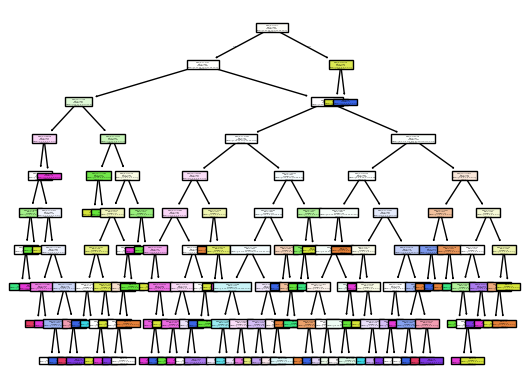

In [67]:
# libraries found on scikit-learn documentation at https://scikit-learn.org/stable/
from sklearn.tree import DecisionTreeClassifier # documentation at https://scikit-learn.org/stable/modules/tree.html
# Decision tree implementation from scikit learn (not self-coded)
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix # documentation at https://scikit-learn.org/stable/modules/model_evaluation.html
# Useful for evaluating the model
from sklearn.preprocessing import LabelEncoder # documentation at https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html
# Needed for transforming the class names into numerical values
from sklearn.tree import plot_tree # To be able to visualise the decision tree
from sklearn.decomposition import PCA # found with AI with the k-NN

# Get the train, validation, and test subsets
train_df = pd.read_csv("train.csv")
val_df = pd.read_csv("val.csv")
test_df = pd.read_csv("test.csv")

def get_pictures(df, transform=None): # largely inspired by AI to have the right configuration of the images
    images = []
    labels = []
    for _, row in df.iterrows():
        try:
            picture = Image.open(row['file']).convert('RGB')
            if transform:
                picture = transform(picture)
                picture = picture.numpy().flatten()
            else:
                picture = picture.resize((224, 224))  # Resize for consistency
                picture = np.array(picture).flatten()  # Flatten the image array
            images.append(picture)
            labels.append(row['class'])
        except Exception as e:
            print(f"Error loading {row['file']}: {e}")
    return np.array(images), np.array(labels)

def clean_nan(X):
    col_means = np.nanmean(X, axis=0)
    inds = np.where(np.isnan(X))
    X[inds] = np.take(col_means, inds[1])
    return X


print("Getting the training subset images")
X_train, y_train = get_pictures(train_df, train_transforms)
pca = PCA(n_components=15) # Keep top n_components components
X_train = clean_nan(X_train)
# Tested with 10, 20, 30
X_train = pca.fit_transform(X_train)
print("Getting the validation subset images")
X_val, y_val = get_pictures(val_df, eval_transforms)
X_val = pca.transform(X_val)
X_val = clean_nan(X_val)
print("Getting the test subset images")
X_test, y_test = get_pictures(test_df, eval_transforms)
X_test = pca.transform(X_test)
X_test = clean_nan(X_test)

# Conversion of the class names (A, AA, AAA, AB, Bits, Bulk, C, PB-I, PB-II) to numerical values
label_encoder = LabelEncoder()
y_train_num = label_encoder.fit_transform(y_train)
y_val_num = label_encoder.transform(y_val)
y_test_num = label_encoder.transform(y_test)
print("Class names converted to numerical values")

# Use the validation set to decide which max_depth to set
print("Initialise max_depth values")
max_depths_to_test = [i for i in range(1,10)] # Values of max_depth to test the decision tree with
best_max_depth = None # to store the value of max_depth inducing the best result for classifying the coffee beans' class
best_result = 0 # to store the best score value obtained with the best value of max_depth
print("Begin best max_depth search")
for i in max_depths_to_test:
    decision_tree = DecisionTreeClassifier(random_state=42, max_depth=i)
    decision_tree.fit(X_train, y_train_num) # fit the decision tree on the training subset
    result = decision_tree.score(X_val, y_val_num) # evaluate the performance of the decision tree trained on the training subset on the validation subset
    if result > best_result:
        best_max_depth = i
        best_result = result
        print("New best score: {} with max_depth = {}".format(best_result, best_max_depth))

print("Final best max_depth = {} with score of {}".format(best_max_depth, best_result))

best_decision_tree = DecisionTreeClassifier(random_state=42, max_depth=best_max_depth)

# Best max_depth found examples:
# - 5 with score of 0.2571428571428571 with n_components = 10
# - 6 with score of 0.34285714285714286 with n_components = 20
# - 8 with score of 0.22857142857142856 with n_components = 30
# - 6 with score of 0.3142857142857143 with n_components = 20

# Now that we have found our value of max_depth, reform a larger (X,y) to fit the best decision tree possible
best_X = np.concatenate((X_train, X_val))
best_y = np.concatenate((y_train_num, y_val_num))
best_decision_tree.fit(best_X, best_y)

# plt.figure(figsize=(20, 10))
plt.figure()
plot_tree(best_decision_tree, 
          # max_depth=2,  # <== only plot first 2 levels
          filled=True, 
          feature_names=[f"pixel_{i}" for i in range(X_train.shape[1])],
          class_names=label_encoder.classes_)
plt.show()

## Evaluation of Decision Tree

Performance of the decision tree with max_depth 9 on the test subset: 
               precision    recall  f1-score   support

           A       0.50      0.38      0.43         8
          AA       0.43      0.67      0.52         9
         AAA       1.00      0.43      0.60         7
          AB       0.67      0.29      0.40         7
        Bits       0.40      0.25      0.31         8
        Bulk       0.00      0.00      0.00         8
           C       0.38      0.75      0.50         8
        PB-I       0.30      0.38      0.33         8
       PB-II       0.42      0.71      0.53         7

    accuracy                           0.43        70
   macro avg       0.45      0.43      0.40        70
weighted avg       0.44      0.43      0.40        70

Test Accuracy: 0.4286
MSE: 8.3429
R² Score: -0.2485



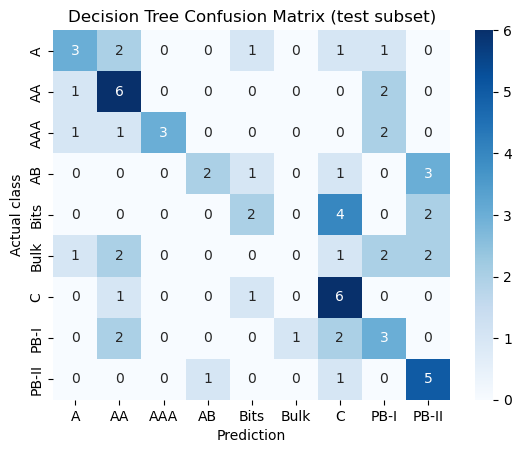

Entire report:               precision    recall  f1-score   support

           A       0.79      0.66      0.72        50
          AA       0.77      0.77      0.77        61
         AAA       0.84      0.84      0.84        50
          AB       0.65      0.26      0.37        50
        Bits       0.58      0.55      0.57        51
        Bulk       0.96      0.48      0.64        50
           C       0.50      0.82      0.62        51
        PB-I       0.80      0.71      0.75        51
       PB-II       0.42      0.74      0.53        50

    accuracy                           0.65       464
   macro avg       0.70      0.65      0.65       464
weighted avg       0.70      0.65      0.65       464

Accuracy on the whole dataset: 0.6509
MSE: 5.6013
R² Score: 0.1644



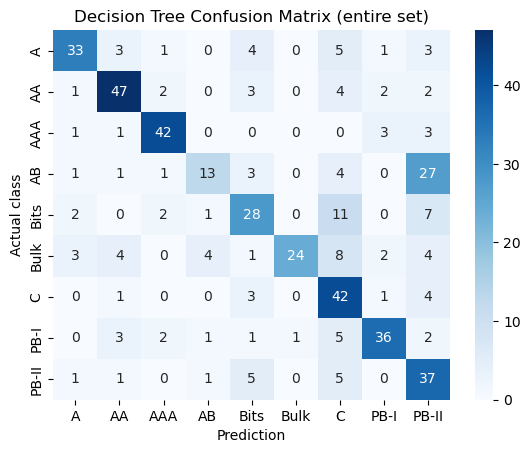

In [68]:
# Determine the final results on the test subset
y_test_prediction_num = best_decision_tree.predict(X_test)
y_test_prediction = label_encoder.inverse_transform(y_test_prediction_num)

classes_true = np.unique(y_test) # found with AI because classes didn't match 9 in the line under
report = classification_report(y_test, y_test_prediction, target_names=classes_true, zero_division=0)
print("Performance of the decision tree with max_depth {} on the test subset: \n {}".format(best_max_depth, report))

test_accuracy = accuracy_score(y_test_num, y_test_prediction_num)
print(f"Test Accuracy: {test_accuracy:.4f}")

best_decision_tree_test_mse = mean_squared_error(label_encoder.transform(y_test), label_encoder.transform(y_test_prediction))
best_decision_tree_test_r2 = r2_score(label_encoder.transform(y_test), label_encoder.transform(y_test_prediction))
print(f"MSE: {best_decision_tree_test_mse:.4f}")
print(f"R² Score: {best_decision_tree_test_r2:.4f}\n")

if isinstance(y_test, np.ndarray):
    y_test = y_test.tolist()
if isinstance(y_test_prediction, np.ndarray):
    y_test_prediction = y_test_prediction.tolist()

# Create the confusion matrix for the test subset
cm_test = confusion_matrix(y_test, y_test_prediction)
plt.figure()
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', xticklabels=classes_true, yticklabels=classes_true)
plt.title('Decision Tree Confusion Matrix (test subset)')
plt.xlabel('Prediction')
plt.ylabel('Actual class')
plt.show()

# Idea: have a look at the confusion matrix for the entire set too
# First, predict the values
X_entire = np.concatenate((best_X, X_test))
y_entire = np.concatenate((label_encoder.inverse_transform(best_y), y_test))
entire_prediction_num = best_decision_tree.predict(X_entire)
entire_prediction = label_encoder.inverse_transform(entire_prediction_num)

entire_report = classification_report(y_entire, entire_prediction, target_names=classes_true, zero_division=0)
print("Entire report: {}".format(entire_report))
entire_accuracy = accuracy_score(y_entire, entire_prediction)
print(f"Accuracy on the whole dataset: {entire_accuracy:.4f}")

best_decision_tree_mse = mean_squared_error(label_encoder.transform(y_entire), label_encoder.transform(entire_prediction))
best_decision_tree_r2 = r2_score(label_encoder.transform(y_entire), label_encoder.transform(entire_prediction))
print(f"MSE: {best_decision_tree_mse:.4f}")
print(f"R² Score: {best_decision_tree_r2:.4f}\n")

# Then, plot the confusion matrix
cm_entire = confusion_matrix(y_entire, entire_prediction)
plt.figure()
sns.heatmap(cm_entire, annot=True, fmt='d', cmap='Blues', xticklabels=classes_true, yticklabels=classes_true)
plt.title('Decision Tree Confusion Matrix (entire set)')
plt.xlabel('Prediction')
plt.ylabel('Actual class')
plt.show()

## K-Nearest Neighbour (KNN)

In [70]:
# libraries found on scikit-learn documentation at https://scikit-learn.org/stable/
from sklearn.neighbors import KNeighborsClassifier # documentation at https://scikit-learn.org/stable/modules/neighbors.html
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix # documentation at https://scikit-learn.org/stable/modules/model_evaluation.html#metrics-and-scoring-quantifying-the-quality-of-predictions
from sklearn.decomposition import PCA # found with AI when searching on how to increase the k-NN algorithm performances
# (it was indeed stuck at 0.171, afterwards at 0.186, and finally at 0.5)
from skimage.feature import hog # Histogram of Oriented Gradients (HOG)
from skimage.color import rgb2gray

# Need to extract additional features for the k-NN to perform well
def extract_features(images):
    features = []
    for picture in images:
        # Conversion of the pictures to gray
        gray_picture = rgb2gray(picture) if len(picture.shape) == 3 else picture
        # Determine the pictures' features
        # First, HOG ones
        detected_features = hog(gray_picture, orientations=8, pixels_per_cell=(16,16), cells_per_block=(1,1), visualize=False)
        # Then, color features
        if len(picture.shape) == 3:
            color_features = [np.mean(picture[:,:,i]) + np.std(picture[:,:,i]) for i in range(3)]
            detected_features = np.concatenate([detected_features, color_features])
        features.append(detected_features)
    return np.array(features)

def clean_nan(X):
    # Replacing NaNs with column means
    col_means = np.nanmean(X, axis=0)
    inds = np.where(np.isnan(X))
    X[inds] = np.take(col_means, inds[1])
    return X


# The function right under is largely inspired by AI to have the right configuration of the images for the functions from the documentation
def trans_img(df, root, transform):
    images = [] # to store the transformed images
    labels = [] # to store the labels from the images
    images_for_features = []
    for _, row in df.iterrows():
        img_path = row['file']
        image = Image.open(img_path).convert('RGB')
        image = transform(image)
        images.append(image.numpy())
        labels.append(row['class'])
        images_for_features.append(image.numpy().transpose(1, 2, 0))
    features = extract_features(np.array(images_for_features))
    return features, np.array(labels)

print("Start training subset images loading")
X_train, y_train = trans_img(train, root, eval_transforms)
X_train = X_train.reshape(X_train.shape[0], -1)
pca = PCA(n_components=15) # keep the top 15 components, features
X_train = pca.fit_transform(X_train)
print("Start validation subset images loading")
X_val, y_val = trans_img(val, root, eval_transforms)
X_val = X_val.reshape(X_val.shape[0], -1)
X_val = pca.transform(X_val)
print("Start test subset images loading")
X_test, y_test = trans_img(test, root, eval_transforms)
X_test = X_test.reshape(X_test.shape[0], -1)
X_test = pca.transform(X_test)


X_train = clean_nan(X_train)
X_val = clean_nan(X_val)
X_test = clean_nan(X_test)

print("Initialise k values")
k_to_test = [i for i in range(2,47)] # Values of k to test the k-NN with
# Since there are 464 images, we are going to test up to having 10% of the population as neighbours, that is to say from k = 2 to 46
best_k = None # to store the value of k inducing the best result for classifying the coffee beans' class
best_result = 0 # to store the best score value obtained with the best value of k


print("Begin best k search")
for k in k_to_test:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train) # fit the k-NN on the training subset
    result = knn.score(X_val, y_val) # evaluate the performance of the k-NN trained on the training subset on the validation subset
    if result > best_result:
        best_k = k
        best_result = result
        print("New best score: {} with k = {}".format(best_result, best_k))

print("Final best k = {} with score of {}".format(best_k, best_result))

best_knn = KNeighborsClassifier(n_neighbors=best_k)
# Now that we have found our value of k, reform a larger (X,y) to fit the best k-NN
best_X = np.concatenate((X_train, X_val))
best_y = np.concatenate((y_train, y_val))
best_knn.fit(best_X, best_y)

# We ran the code right above several times, with our different implementations here are the results:
# - 3 with score of 0.17142857142857143
# - 41 with score of 0.18571428571428572
# - 8 with score of 0.5 (3rd try with PCA limited to 4)
# - 13 with score of 0.5714285714285714 (3rd try with PCA limited to 10)
# - 14 with score of 0.5285714285714286 (3rd try with PCA limited to 10)

Start training subset images loading
Start validation subset images loading
Start test subset images loading
Initialise k values
Begin best k search
New best score: 0.38571428571428573 with k = 2
New best score: 0.4142857142857143 with k = 4
New best score: 0.44285714285714284 with k = 9
New best score: 0.45714285714285713 with k = 11
New best score: 0.4714285714285714 with k = 12
New best score: 0.5142857142857142 with k = 17
Final best k = 17 with score of 0.5142857142857142


,n_neighbors,17
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


## Evaluation of KNN 


Test Accuracy: 0.5571428571428572
17-NN performance on the test subset: 
               precision    recall  f1-score   support

           A       0.50      0.38      0.43         8
          AA       0.33      0.44      0.38         9
         AAA       0.75      0.43      0.55         7
          AB       0.50      0.43      0.46         7
        Bits       0.78      0.88      0.82         8
        Bulk       0.50      0.50      0.50         8
           C       1.00      0.50      0.67         8
        PB-I       0.50      0.88      0.64         8
       PB-II       0.57      0.57      0.57         7

    accuracy                           0.56        70
   macro avg       0.60      0.56      0.56        70
weighted avg       0.60      0.56      0.56        70

MSE: 5.5143
R² Score: 0.1748



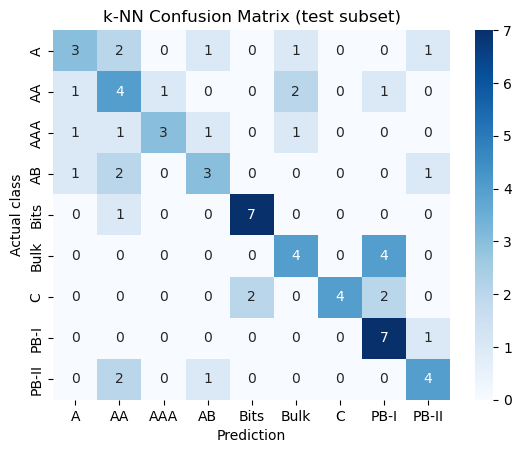

Entire report: 
               precision    recall  f1-score   support

           A       0.52      0.58      0.55        50
          AA       0.49      0.43      0.46        61
         AAA       0.66      0.54      0.59        50
          AB       0.68      0.88      0.77        50
        Bits       0.80      0.94      0.86        51
        Bulk       0.66      0.74      0.70        50
           C       0.94      0.61      0.74        51
        PB-I       0.59      0.78      0.67        51
       PB-II       0.69      0.44      0.54        50

    accuracy                           0.66       464
   macro avg       0.67      0.66      0.65       464
weighted avg       0.67      0.66      0.65       464

Accuracy on the whole dataset: 0.6552
MSE: 5.7284
R² Score: 0.1454



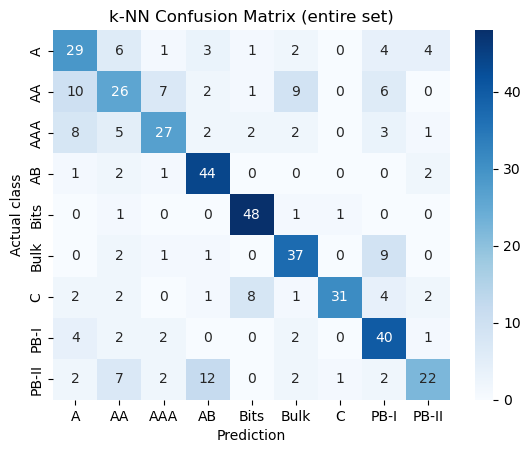

In [71]:
# Now comes the time to test the performances on the testing subset
y_test_prediction = best_knn.predict(X_test)
classes_true = np.unique(y_test) # found with AI because classes didn't match 9 in the line under
print("\nTest Accuracy:", accuracy_score(y_test, y_test_prediction))
report = classification_report(y_test, y_test_prediction, target_names=classes_true, zero_division=0)
print("{}-NN performance on the test subset: \n {}".format(best_k, report))

best_knn_test_mse = mean_squared_error(label_encoder.transform(y_test), label_encoder.transform(y_test_prediction))
best_knn_test_r2 = r2_score(label_encoder.transform(y_test), label_encoder.transform(y_test_prediction))
print(f"MSE: {best_knn_test_mse:.4f}")
print(f"R² Score: {best_knn_test_r2:.4f}\n")

if isinstance(y_test, np.ndarray):
    y_test = y_test.tolist()
if isinstance(y_test_prediction, np.ndarray):
    y_test_prediction = y_test_prediction.tolist()

# Create the confusion matrix for the test subset
cm_test = confusion_matrix(y_test, y_test_prediction)
plt.figure()
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', xticklabels=classes_true, yticklabels=classes_true)
plt.title('k-NN Confusion Matrix (test subset)')
plt.xlabel('Prediction')
plt.ylabel('Actual class')
plt.show()

# Idea: have a look at the confusion matrix for the entire set too
# First, predict the values
X_entire = np.concatenate((best_X, X_test))
y_entire = np.concatenate((best_y, y_test))
entire_prediction = best_knn.predict(X_entire)
entire_report = classification_report(y_entire, entire_prediction, target_names=classes_true, zero_division=0)
print("Entire report: \n {}".format(entire_report))
entire_accuracy = accuracy_score(y_entire, entire_prediction)
print(f"Accuracy on the whole dataset: {entire_accuracy:.4f}")

best_knn_mse = mean_squared_error(label_encoder.transform(y_entire), label_encoder.transform(entire_prediction))
best_knn_r2 = r2_score(label_encoder.transform(y_entire), label_encoder.transform(entire_prediction))
print(f"MSE: {best_knn_mse:.4f}")
print(f"R² Score: {best_knn_r2:.4f}\n")

# Then, plot the confusion matrix
cm_entire = confusion_matrix(y_entire, entire_prediction)
plt.figure()
sns.heatmap(cm_entire, annot=True, fmt='d', cmap='Blues', xticklabels=classes_true, yticklabels=classes_true)
plt.title('k-NN Confusion Matrix (entire set)')
plt.xlabel('Prediction')
plt.ylabel('Actual class')
plt.show()

## Logistic Regression

Using existing PCA-reduced features:
X_train shape: (324, 15)
X_val shape: (70, 15)
X_test shape: (70, 15)

Training Logistic Regression...
New best validation accuracy of 0.4286 for max_iter = 0
New best validation accuracy of 0.5714 for max_iter = 10


/home/astrid/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 0 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=0).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/astrid/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 10 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=10).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please a

Final best validation accuracy of 0.5714 for max_iter = 10

Test Accuracy (Logistic Regression): 0.5571

Test Classification Report:
              precision    recall  f1-score   support

           A       0.38      0.38      0.38         8
          AA       0.57      0.44      0.50         9
         AAA       0.50      0.57      0.53         7
          AB       0.60      0.43      0.50         7
        Bits       0.67      0.75      0.71         8
        Bulk       0.83      0.62      0.71         8
           C       0.40      0.25      0.31         8
        PB-I       0.58      0.88      0.70         8
       PB-II       0.50      0.71      0.59         7

    accuracy                           0.56        70
   macro avg       0.56      0.56      0.55        70
weighted avg       0.56      0.56      0.55        70

MSE: 5.1143
R² Score: 0.2347



/home/astrid/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 10 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=10).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


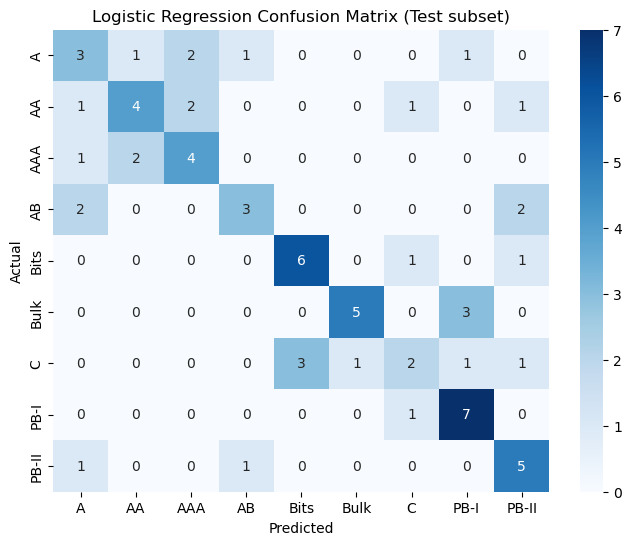


Accuracy on the whole dataset: 0.6746

 Entire report: 
               precision    recall  f1-score   support

           A       0.53      0.56      0.54        50
          AA       0.53      0.49      0.51        61
         AAA       0.62      0.68      0.65        50
          AB       0.77      0.80      0.78        50
        Bits       0.84      0.84      0.84        51
        Bulk       0.80      0.78      0.79        50
           C       0.72      0.65      0.68        51
        PB-I       0.71      0.78      0.75        51
       PB-II       0.58      0.52      0.55        50

    accuracy                           0.67       464
   macro avg       0.68      0.68      0.68       464
weighted avg       0.67      0.67      0.67       464



ValueError: could not convert string to float: 'Bits'

In [73]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

print("Using existing PCA-reduced features:")
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)


# Training Logistic Regression using the validation subset for tuning the max_iter parameter
max_iter_to_test = [10 * i for i in range(501)]
best_max_iter = None
best_val_accuracy = 0

print("\nTraining Logistic Regression...")
for k in max_iter_to_test:
    log_reg = LogisticRegression(
        max_iter=k,          
        solver='lbfgs',          # multi-class solver
        # multi_class='multinomial' # no longer of use due to evolution of the function, it's automatically like this
    )
    log_reg.fit(X_train, y_train_num)
    val_prediction_num = log_reg.predict(X_val)
    val_accuracy = accuracy_score(y_val_num, val_prediction_num)
    if val_accuracy > best_val_accuracy:
        best_max_iter = k
        best_val_accuracy = val_accuracy
        print("New best validation accuracy of {:.4f} for max_iter = {}".format(best_val_accuracy, best_max_iter))

print("Final best validation accuracy of {:.4f} for max_iter = {}".format(best_val_accuracy, best_max_iter))

log_reg = LogisticRegression(
        max_iter=best_max_iter,          
        solver='lbfgs',          # multi-class solver
        # multi_class='multinomial' # no longer of use due to evolution of the function, it's automatically like this
    )
log_reg.fit(X_train, y_train_num)


# TESTING SUBSET

y_test_pred_num = log_reg.predict(X_test)
test_accuracy = accuracy_score(y_test_num, y_test_pred_num)
print(f"\nTest Accuracy (Logistic Regression): {test_accuracy:.4f}")

y_test_pred = label_encoder.inverse_transform(y_test_pred_num)
y_test_true = label_encoder.inverse_transform(y_test_num)

print("\nTest Classification Report:")
print(classification_report(y_test_true, y_test_pred, target_names=classes, zero_division=0))

best_logistic_regression_test_mse = mean_squared_error(y_test_num, y_test_pred_num)
best_logistic_regression_test_r2 = r2_score(y_test_num, y_test_pred_num)
print(f"MSE: {best_logistic_regression_test_mse:.4f}")
print(f"R² Score: {best_logistic_regression_test_r2:.4f}\n")

# Confusion Matrix (Test subset)
cm_test = confusion_matrix(y_test_true, y_test_pred, labels=classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.title("Logistic Regression Confusion Matrix (Test subset)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


# ENTIRE SET

best_X = np.concatenate((X_train, X_val))
best_y = np.concatenate((y_train, y_val))
X_entire = np.concatenate((best_X, X_test))
y_entire = np.concatenate((best_y, y_test))
entire_prediction = log_reg.predict(X_entire)

entire_prediction_true = label_encoder.inverse_transform(entire_prediction)
entire_accuracy = accuracy_score(y_entire, entire_prediction_true)
print(f"\nAccuracy on the whole dataset: {entire_accuracy:.4f}")

entire_report = classification_report(y_entire, entire_prediction_true, target_names=classes_true, zero_division=0)
print("\n Entire report: \n {}".format(entire_report))

best_logistic_regression_mse = mean_squared_error(label_encoder.transform(y_entire), entire_prediction)
best_logistic_regression_r2 = r2_score(label_encoder.transform(y_entire), entire_prediction)
print(f"MSE: {best_logistic_regression_mse:.4f}")
print(f"R² Score: {best_logistic_regression_r2:.4f}\n")

# Then, plot the confusion matrix (for the entire set)
cm_entire = confusion_matrix(y_entire, entire_prediction_true)
plt.figure()
# sns.heatmap(cm_entire, annot=True, fmt='d', cmap='Blues', xticklabels=classes_true, yticklabels=classes_true)
sns.heatmap(cm_entire, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Logistic Regression Confusion Matrix (Entire set)')
plt.xlabel('Prediction')
plt.ylabel('Actual class')
plt.show()

## R4: Neural Networks

In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

# Custom dataset class
class CoffeeBeanDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)
        self.transform = transform
        self.classes = sorted(self.data['class'].unique())
        self.class_to_idx = {c: i for i, c in enumerate(self.classes)}

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data.iloc[idx]['file']
        label = self.class_to_idx[self.data.iloc[idx]['class']]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

train_ds = CoffeeBeanDataset("train.csv", train_transforms)
val_ds   = CoffeeBeanDataset("val.csv", eval_transforms)
test_ds  = CoffeeBeanDataset("test.csv", eval_transforms)

# Using Apple MPS GPU
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using Apple GPU")
else:
    device = torch.device("cpu")
    print("Using CPU")

# Loading a pretrained CNN for Transfer Learning
model = models.resnet18(weights=True)

# Fine tuning

#for param in model.parameters():
    #param.requires_grad = False

for name, param in model.named_parameters():
    if "layer4" in name or "fc" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False  # keeping previous layers frozen

# Adjusting pre-trained model to our dataset
num_classes = len(train_ds.classes) 
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device) # to make sure the model runs on GPU

# For Loss, Optimizing and Scheduling
criterion = nn.CrossEntropyLoss()  # for measuring accuracy
#optimizer = optim.Adam(model.fc.parameters(), lr=1e-3) #starting at 0.001

params= []
for param in model.parameters():
    if param.requires_grad:
        params.append(param)

optimizer = optim.Adam(params, lr=1e-4) # starting at 0.0001
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1) 

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=32, shuffle=False)

print(f"Train batches: {len(train_loader)} , Validation batches: {len(val_loader)} , Testing batches: {len(test_loader)}")

# Training model
num_epochs = 20
best_validation = 0

for epoch in range(num_epochs):
    model.train()
    total_loss, correct, total = 0, 0, 0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"): #using tqdm for checking progress
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()  # removing previous error before new batch training

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss = total_loss + loss.item()
        _, predicted = outputs.max(1)  # finding the highest scores
        total = total + labels.size(0)
        correct = correct + predicted.eq(labels).sum().item()

    training_acc = 100 * (correct / total)

    # Validation
    model.eval()
    val_correct = 0 
    val_total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            val_total = val_total + labels.size(0)
            val_correct = val_correct + predicted.eq(labels).sum().item()

    val_acc = 100 * (val_correct / val_total)
    print(f"Epoch [{epoch+1}/{num_epochs}]  Loss: {total_loss:.3f}  Train Acc: {training_acc:.2f}%  Val Acc: {val_acc:.2f}%")

    if val_acc > best_validation:
        best_validation = val_acc
        torch.save(model.state_dict(), "best_resnet18.pt")

    scheduler.step()

print(f"Training is completed. Best validation accuracy is: {best_validation:.2f}%")


Using CPU


/home/astrid/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Train batches: 11 , Validation batches: 3 , Testing batches: 3


Epoch 1/20: 100%|███████████████████████████████| 11/11 [00:51<00:00,  4.65s/it]


Epoch [1/20]  Loss: 24.194  Train Acc: 19.75%  Val Acc: 25.71%


Epoch 2/20: 100%|███████████████████████████████| 11/11 [00:48<00:00,  4.42s/it]


Epoch [2/20]  Loss: 19.588  Train Acc: 40.12%  Val Acc: 41.43%


Epoch 3/20: 100%|███████████████████████████████| 11/11 [00:49<00:00,  4.51s/it]


Epoch [3/20]  Loss: 16.708  Train Acc: 48.15%  Val Acc: 42.86%


Epoch 4/20: 100%|███████████████████████████████| 11/11 [00:47<00:00,  4.33s/it]


Epoch [4/20]  Loss: 14.032  Train Acc: 58.02%  Val Acc: 42.86%


Epoch 5/20: 100%|███████████████████████████████| 11/11 [00:46<00:00,  4.21s/it]


Epoch [5/20]  Loss: 12.711  Train Acc: 60.80%  Val Acc: 57.14%


Epoch 6/20: 100%|███████████████████████████████| 11/11 [00:48<00:00,  4.37s/it]


Epoch [6/20]  Loss: 11.760  Train Acc: 63.89%  Val Acc: 58.57%


Epoch 7/20: 100%|███████████████████████████████| 11/11 [00:45<00:00,  4.16s/it]


Epoch [7/20]  Loss: 12.379  Train Acc: 65.43%  Val Acc: 65.71%


Epoch 8/20: 100%|███████████████████████████████| 11/11 [00:48<00:00,  4.42s/it]


Epoch [8/20]  Loss: 11.781  Train Acc: 66.67%  Val Acc: 72.86%


Epoch 9/20: 100%|███████████████████████████████| 11/11 [00:47<00:00,  4.32s/it]


Epoch [9/20]  Loss: 12.208  Train Acc: 65.12%  Val Acc: 74.29%


Epoch 10/20: 100%|██████████████████████████████| 11/11 [00:48<00:00,  4.42s/it]


Epoch [10/20]  Loss: 12.642  Train Acc: 62.35%  Val Acc: 74.29%


Epoch 11/20: 100%|██████████████████████████████| 11/11 [00:48<00:00,  4.42s/it]


Epoch [11/20]  Loss: 11.879  Train Acc: 64.81%  Val Acc: 71.43%


Epoch 12/20: 100%|██████████████████████████████| 11/11 [00:47<00:00,  4.29s/it]


Epoch [12/20]  Loss: 11.518  Train Acc: 69.14%  Val Acc: 72.86%


Epoch 13/20: 100%|██████████████████████████████| 11/11 [00:47<00:00,  4.33s/it]


Epoch [13/20]  Loss: 11.694  Train Acc: 66.05%  Val Acc: 74.29%


Epoch 14/20: 100%|██████████████████████████████| 11/11 [00:48<00:00,  4.41s/it]


Epoch [14/20]  Loss: 11.187  Train Acc: 67.28%  Val Acc: 74.29%


Epoch 15/20: 100%|██████████████████████████████| 11/11 [00:47<00:00,  4.36s/it]


Epoch [15/20]  Loss: 12.125  Train Acc: 64.20%  Val Acc: 71.43%


Epoch 16/20: 100%|██████████████████████████████| 11/11 [00:49<00:00,  4.53s/it]


Epoch [16/20]  Loss: 10.874  Train Acc: 69.75%  Val Acc: 74.29%


Epoch 17/20: 100%|██████████████████████████████| 11/11 [00:50<00:00,  4.58s/it]


Epoch [17/20]  Loss: 10.896  Train Acc: 70.37%  Val Acc: 74.29%


Epoch 18/20: 100%|██████████████████████████████| 11/11 [00:48<00:00,  4.39s/it]


Epoch [18/20]  Loss: 11.308  Train Acc: 68.83%  Val Acc: 72.86%


Epoch 19/20: 100%|██████████████████████████████| 11/11 [00:50<00:00,  4.57s/it]


Epoch [19/20]  Loss: 11.691  Train Acc: 72.22%  Val Acc: 74.29%


Epoch 20/20: 100%|██████████████████████████████| 11/11 [00:49<00:00,  4.50s/it]


Epoch [20/20]  Loss: 12.079  Train Acc: 70.37%  Val Acc: 70.00%
Training is completed. Best validation accuracy is: 74.29%


## Neural Networks Evaluation

In [27]:
model.load_state_dict(torch.load("best_resnet18.pt", map_location=device))
model.eval()

y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = outputs.max(1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=train_ds.classes))



Classification Report:
              precision    recall  f1-score   support

           A       0.88      0.88      0.88         8
          AA       0.58      0.78      0.67         9
         AAA       0.75      0.86      0.80         7
          AB       1.00      0.29      0.44         7
        Bits       1.00      0.88      0.93         8
        Bulk       0.86      0.75      0.80         8
           C       0.86      0.75      0.80         8
        PB-I       1.00      0.88      0.93         8
       PB-II       0.58      1.00      0.74         7

    accuracy                           0.79        70
   macro avg       0.83      0.78      0.78        70
weighted avg       0.83      0.79      0.78        70



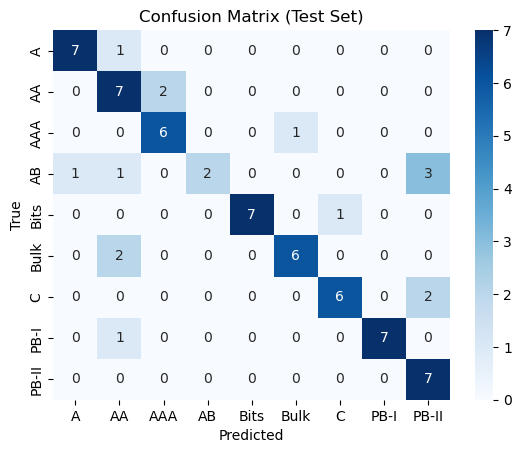

In [28]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=train_ds.classes,
            yticklabels=train_ds.classes)
plt.title("Confusion Matrix (Test Set)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()
